<a href="https://colab.research.google.com/github/shishiraiyar/disastometer/blob/main/Disaster_training_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
!git clone https://github.com/tariqshaban/disaster-classification-with-xai.git
!mkdir assets
!cp -r ./disaster-classification-with-xai/assets/disaster_data ./assets/disaster_data
!rm -rf disaster-classification-with-xai/

Cloning into 'disaster-classification-with-xai'...
remote: Enumerating objects: 13478, done.
remote: Counting objects: 100% (3497/3497), done.
remote: Compressing objects: 100% (3493/3493), done.
remote: Total 13478 (delta 6), reused 3491 (delta 4), pack-reused 9981
Receiving objects: 100% (13478/13478), 658.45 MiB | 33.19 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (13570/13570), done.


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
imgDataGen = ImageDataGenerator(validation_split=0.2)
train_ds = imgDataGen.flow_from_directory(directory="./assets/disaster_data",
                                            target_size=(img_height, img_width),
                                            batch_size=batch_size,
                                            seed=123,
                                            subset="training",
                                            class_mode='sparse')

val_ds =   imgDataGen.flow_from_directory(directory="./assets/disaster_data",
                                            target_size=(img_height, img_width),
                                            batch_size=batch_size,
                                            seed=123,
                                            subset="validation",
                                            class_mode='sparse')


Found 10849 images belonging to 12 classes.
Found 2707 images belonging to 12 classes.


In [ ]:
class_indices = train_ds.class_indices

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda

from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
preprocessing_layer = Lambda(preprocess_input, input_shape=(180, 180, 3))

In [ ]:
baseModel = ResNet50(weights='imagenet', include_top=False)
baseModel.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model = Sequential(
    [   preprocessing_layer,
        baseModel,
        Layer(),
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(len(class_indices), activation='softmax')
    ]
)


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 layer (Layer)               (None, 6, 6, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 12)                2

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=4)
# Decrease patience

In [ ]:
train_history = model.fit(x=train_ds, validation_data=val_ds, epochs=10, callbacks=[es])

Epoch 1/10
340/340 [==============================] - 78s 205ms/step - loss: 0.6680 - accuracy: 0.8130 - val_loss: 0.2938 - val_accuracy: 0.9143
Epoch 2/10
340/340 [==============================] - 53s 154ms/step - loss: 0.3414 - accuracy: 0.8938 - val_loss: 0.2565 - val_accuracy: 0.9261
Epoch 3/10
340/340 [==============================] - 50s 146ms/step - loss: 0.2932 - accuracy: 0.9086 - val_loss: 0.2586 - val_accuracy: 0.9239
Epoch 4/10
340/340 [==============================] - 52s 153ms/step - loss: 0.2748 - accuracy: 0.9141 - val_loss: 0.2749 - val_accuracy: 0.9209
Epoch 5/10
340/340 [==============================] - 52s 152ms/step - loss: 0.2568 - accuracy: 0.9134 - val_loss: 0.2660 - val_accuracy: 0.9213
Epoch 6/10
340/340 [==============================] - 54s 158ms/step - loss: 0.2313 - accuracy: 0.9249 - val_loss: 0.2758 - val_accuracy: 0.9221
Epoch 6: early stopping


In [ ]:
train_history.history

{'loss': [0.6680041551589966,
  0.341397762298584,
  0.29316940903663635,
  0.27481842041015625,
  0.25684410333633423,
  0.2313060313463211],
 'accuracy': [0.8129781484603882,
  0.8938151001930237,
  0.9085630178451538,
  0.9140934944152832,
  0.9134482145309448,
  0.9248778820037842],
 'val_loss': [0.2938386797904968,
  0.2565203309059143,
  0.2586478590965271,
  0.2748575210571289,
  0.26600366830825806,
  0.2757797837257385],
 'val_accuracy': [0.9142962694168091,
  0.926117479801178,
  0.9239010214805603,
  0.9209457039833069,
  0.9213151335716248,
  0.9220539331436157]}

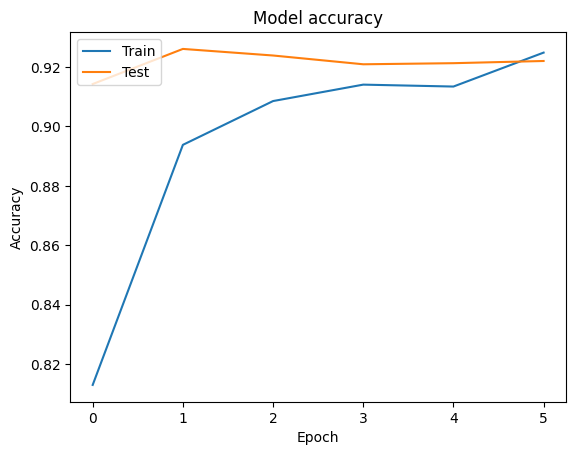

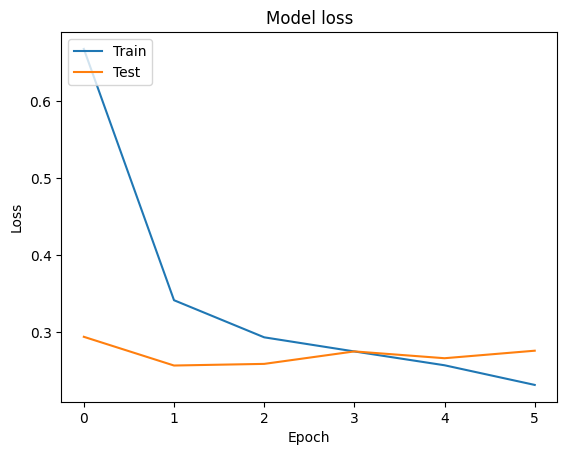

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.save("./model.keras")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !mkdir /content/drive/MyDrive/models

Mounted at /content/drive


In [ ]:
!mkdir /content/drive/MyDrive/models/disaster

In [ ]:
model.save("/content/drive/MyDrive/models/disaster/model.keras")

In [ ]:
classNames = [None for _ in range(len(class_indices))]
for (key, value) in class_indices.items():
  classNames[value] = key
classNames

['drought',
 'earthquake',
 'human_damage',
 'infrastructure',
 'land_slide',
 'non_damage_buildings_street',
 'non_damage_human',
 'non_damage_sea',
 'non_damage_wildlife_forest',
 'urban_fire',
 'water_disaster',
 'wild_fire']

In [ ]:
opStr = ""
for c in classNames:
    opStr += c + "\n"
opStr = opStr.strip()

with open("/content/drive/MyDrive/models/disaster/classes.txt", "w") as file:
    file.write(opStr)